# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [1]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('../models/cnn/best_model.keras')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<Figure size 1000x400 with 0 Axes>

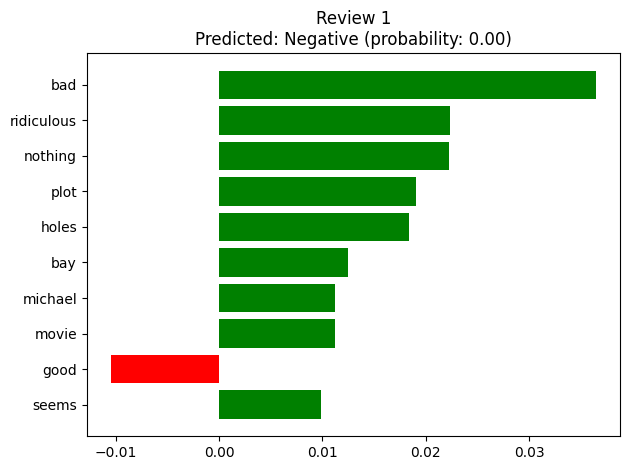


Review 1:
Text: nothing special special affects time cant tell youre looking everything dark gritty explosions time ...

Top contributing words:
bad: 0.036
ridiculous: 0.022
nothing: 0.022
plot: 0.019
holes: 0.018
bay: 0.012
michael: 0.011
movie: 0.011
good: -0.010
seems: 0.010


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

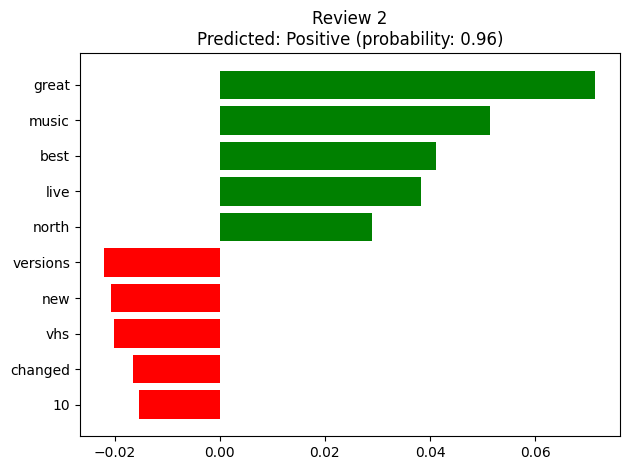


Review 2:
Text: band brown album classic series videos came could wish anything band brown album 2nd album highlight...

Top contributing words:
great: 0.072
music: 0.051
best: 0.041
live: 0.038
north: 0.029
versions: -0.022
new: -0.021
vhs: -0.020
changed: -0.017
10: -0.015


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

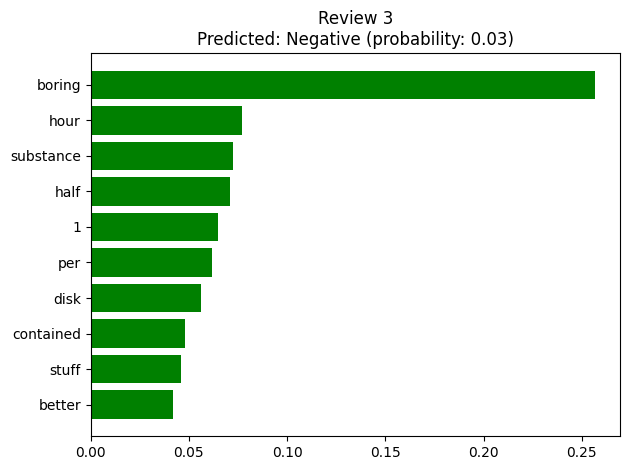


Review 3:
Text: worth surprisingly contained little substance 1 half hour workout per disk got boring fast found bet...

Top contributing words:
boring: 0.257
hour: 0.077
substance: 0.073
half: 0.071
1: 0.065
per: 0.062
disk: 0.056
contained: 0.048
stuff: 0.046
better: 0.042


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

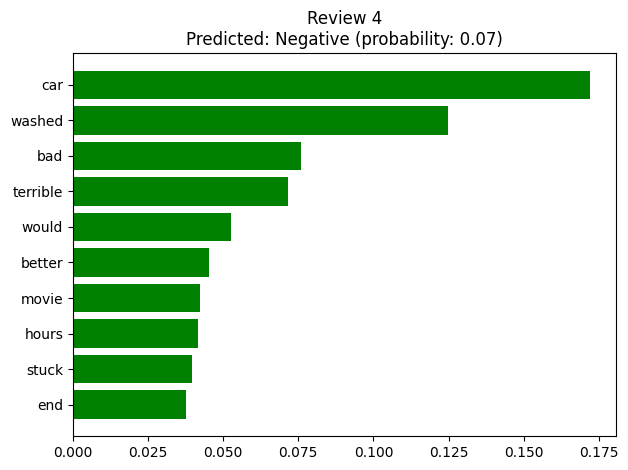


Review 4:
Text: bad lieutenant terrible movie beginning end stuck see would get better two hours later wished gone s...

Top contributing words:
car: 0.172
washed: 0.125
bad: 0.076
terrible: 0.072
would: 0.053
better: 0.045
movie: 0.042
hours: 0.042
stuck: 0.040
end: 0.038


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

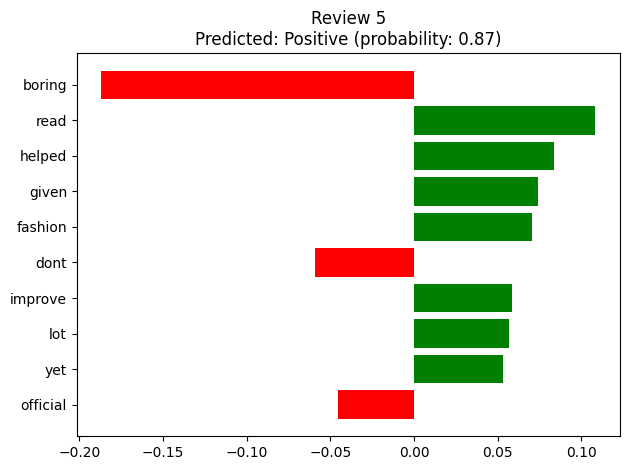


Review 5:
Text: general good book took toefl test morning say book useful havent received official grades yet note 2...

Top contributing words:
boring: -0.187
read: 0.108
helped: 0.083
given: 0.074
fashion: 0.070
dont: -0.059
improve: 0.059
lot: 0.056
yet: 0.053
official: -0.046




In [2]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")